In [1]:
# Setup & Imports
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Reproducibility
SEED = 42
np.random.seed(SEED)

# Plotting style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("Set2")

# Environment info (helpful for debugging)
print("Python:", sys.version.split()[0])
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("Seaborn:", sns.__version__)
print("Matplotlib:", plt.matplotlib.__version__)


Python: 3.12.11
Pandas: 2.2.2
NumPy: 2.0.2
Seaborn: 0.13.2
Matplotlib: 3.10.0


In [2]:
# Load & Inspect Dataset
DATA_PATH = "/content/dataset.csv"

# Load the dataset
df = pd.read_csv(DATA_PATH)

# Display first 5 rows to understand the structure
print("\n--- First 5 Rows ---")
display(df.head())

# Basic info about columns, data types, and non-null counts
print("\n--- Data Info ---")
df.info()

# Basic statistical summary for numerical features
print("\n--- Summary Statistics ---")
display(df.describe())

# Check for missing values in each column
print("\n--- Missing Values ---")
print(df.isnull().sum())


--- First 5 Rows ---


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0



--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB

--- Summary Statistics ---


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,53.720168,0.763866,3.232773,132.153782,210.363866,0.213445,0.698319,139.732773,0.387395,0.922773,1.624370,0.528571
std,9.358203,0.424884,0.935480,18.368823,101.420489,0.409912,0.870359,25.517636,0.487360,1.086337,0.610459,0.499393
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,188.000000,0.000000,0.000000,121.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,229.000000,0.000000,0.000000,140.500000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,269.750000,0.000000,2.000000,160.000000,1.000000,1.600000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000



--- Missing Values ---
age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64


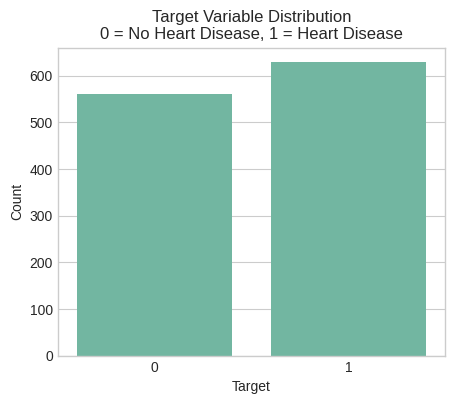

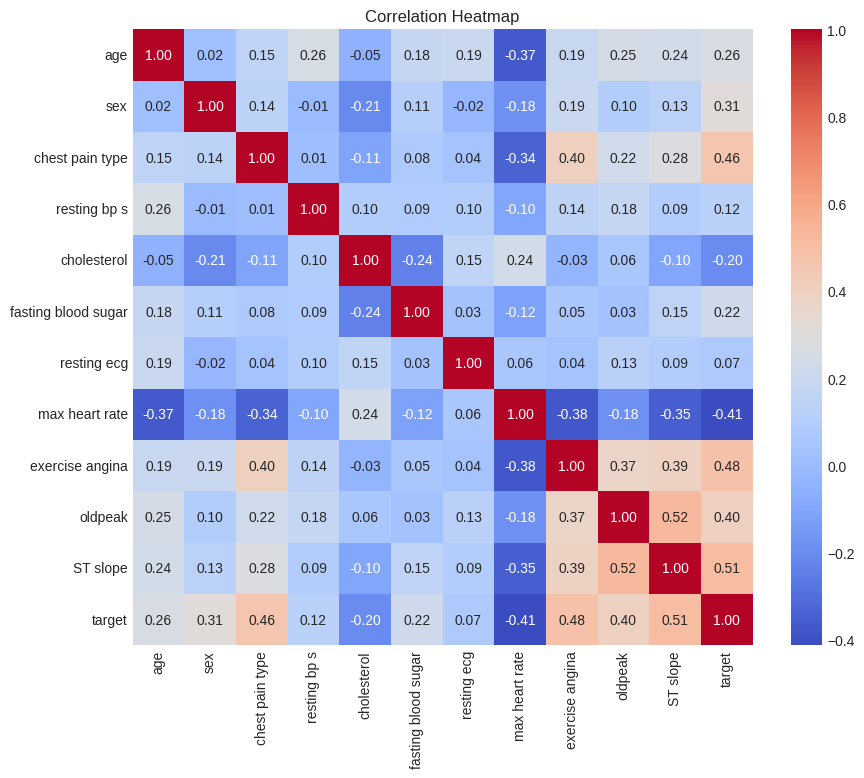

<Figure size 1200x600 with 0 Axes>

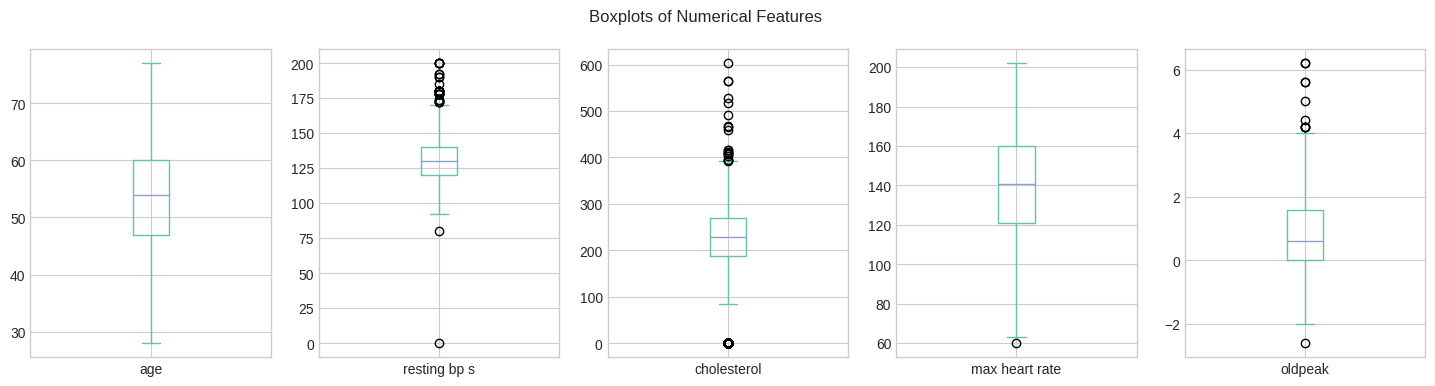

In [3]:
# Basic Exploratory Data Analysis


# Target variable distribution
plt.figure(figsize=(5,4))
sns.countplot(x='target', data=df)
plt.title('Target Variable Distribution\n0 = No Heart Disease, 1 = Heart Disease')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Quick boxplots to spot outliers for key numerical features
num_cols = ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']
plt.figure(figsize=(12,6))
df[num_cols].plot(kind='box', subplots=True, layout=(1, len(num_cols)), figsize=(18,4), sharey=False)
plt.suptitle('Boxplots of Numerical Features')
plt.show()

In [4]:
# Data Preprocessing

# Separate features (X) and target (y)
X = df.drop(columns=['target'])
y = df['target']

# Identify numerical columns for scaling
numeric_features = ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']

# Initialize scaler
scaler = StandardScaler()

# Apply scaling to numerical columns
X_scaled = X.copy()
X_scaled[numeric_features] = scaler.fit_transform(X[numeric_features])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=SEED
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Target distribution in train set:\n{y_train.value_counts(normalize=True)}")

Training set shape: (952, 11)
Test set shape: (238, 11)
Target distribution in train set:
target
1    0.528361
0    0.471639
Name: proportion, dtype: float64


=== Logistic Regression Baseline Results ===
Accuracy:  0.8403
Precision: 0.8438
Recall:    0.8571
F1 Score:  0.8504
ROC-AUC:   0.9049


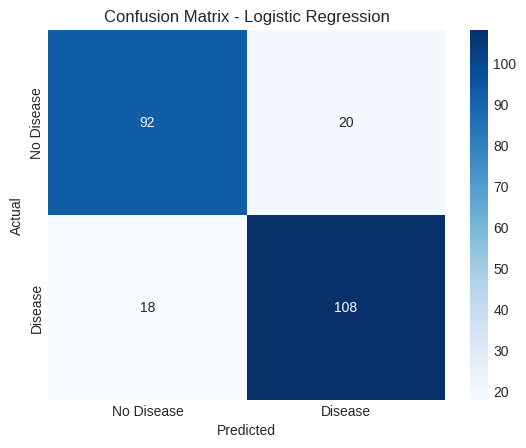

In [5]:
# Baseline Model - Logistic Regression


# Initialize the model
log_reg = LogisticRegression(random_state=SEED, max_iter=1000)

# Train the model
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]  # For ROC-AUC

# Evaluation metrics
print("=== Logistic Regression Baseline Results ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

=== Random Forest Results ===
Accuracy:  0.9160
Precision: 0.9274
Recall:    0.9127
F1 Score:  0.9200
ROC-AUC:   0.9785


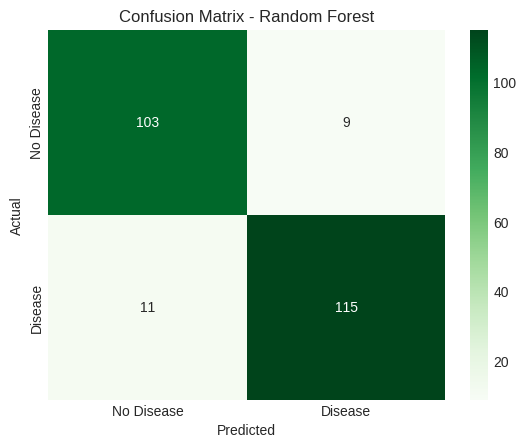

In [6]:
# Model 2 - Random Forest Classifier


# Initialize model
rf_clf = RandomForestClassifier(
    n_estimators=200,        # Number of trees
    max_depth=None,          # Let trees expand fully
    random_state=SEED,
    class_weight='balanced'  # Handle slight class imbalance
)

# Train the model
rf_clf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("=== Random Forest Results ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba_rf):.4f}")

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

=== XGBoost Results ===
Accuracy:  0.9244
Precision: 0.9219
Recall:    0.9365
F1 Score:  0.9291
ROC-AUC:   0.9656


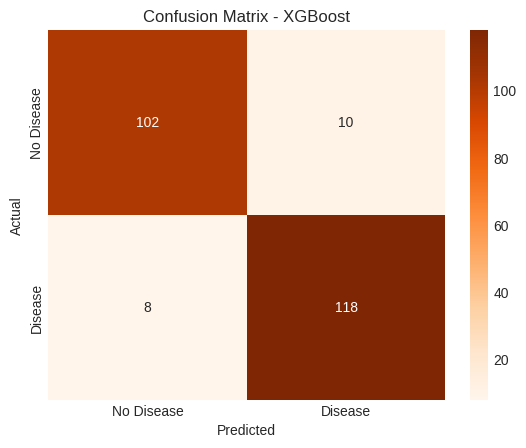

In [7]:
# Model 3 - XGBoost Classifier

from xgboost import XGBClassifier

# Initialize model
xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=SEED
)

# Train the model
xgb_clf.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_clf.predict(X_test)
y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("=== XGBoost Results ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba_xgb):.4f}")

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

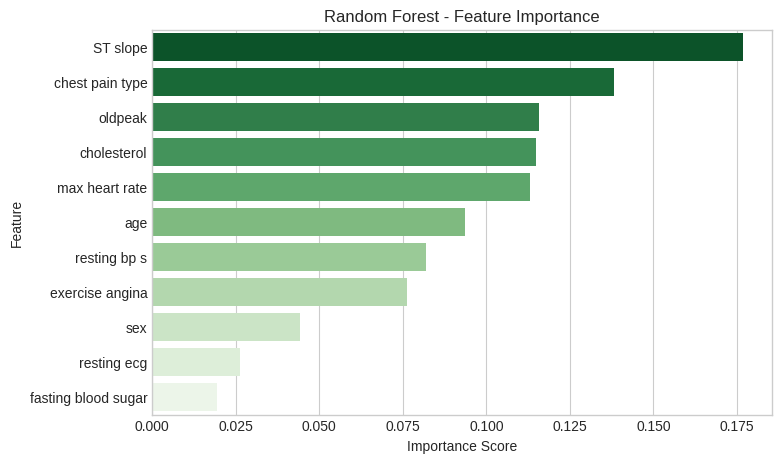


Top 5 features (Random Forest):
ST slope           0.176675
chest pain type    0.138244
oldpeak            0.115876
cholesterol        0.114767
max heart rate     0.112909
dtype: float64


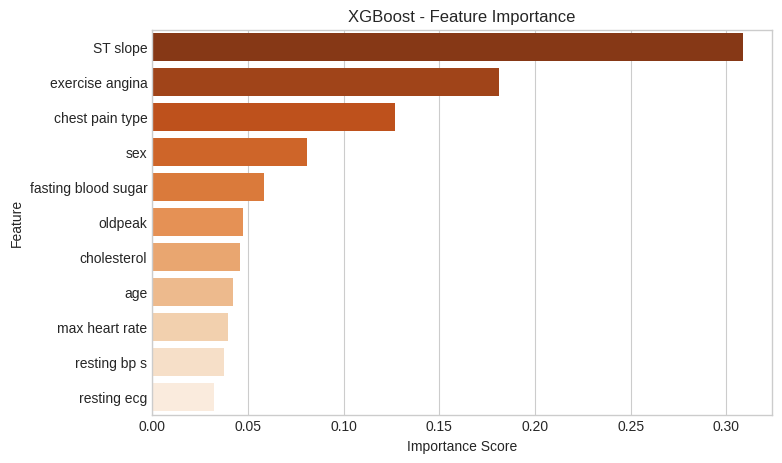


Top 5 features (XGBoost):
ST slope               0.308546
exercise angina        0.181175
chest pain type        0.126953
sex                    0.080703
fasting blood sugar    0.058256
dtype: float32


In [8]:
# Feature Importance Analysis

# Random Forest Feature Importances
rf_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=rf_importances, y=rf_importances.index, palette="Greens_r")
plt.title("Random Forest - Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

print("\nTop 5 features (Random Forest):")
print(rf_importances.head())

# XGBoost Feature Importances
xgb_importances = pd.Series(xgb_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=xgb_importances, y=xgb_importances.index, palette="Oranges_r")
plt.title("XGBoost - Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

print("\nTop 5 features (XGBoost):")
print(xgb_importances.head())

In [9]:
# Stratified K-Fold Cross-Validation

from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define Stratified K-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

models = {
    "Random Forest": rf_clf,
    "XGBoost": xgb_clf
}

cv_results = {}

for name, model in models.items():
    print(f"\n=== {name} Cross-Validation ===")
    accuracy = cross_val_score(model, X_scaled, y, cv=kfold, scoring='accuracy')
    precision = cross_val_score(model, X_scaled, y, cv=kfold, scoring='precision')
    recall = cross_val_score(model, X_scaled, y, cv=kfold, scoring='recall')
    f1 = cross_val_score(model, X_scaled, y, cv=kfold, scoring='f1')
    roc_auc = cross_val_score(model, X_scaled, y, cv=kfold, scoring='roc_auc')

    cv_results[name] = {
        "Accuracy": accuracy.mean(),
        "Precision": precision.mean(),
        "Recall": recall.mean(),
        "F1 Score": f1.mean(),
        "ROC-AUC": roc_auc.mean()
    }

    print(f"Accuracy:  {accuracy.mean():.4f} ± {accuracy.std():.4f}")
    print(f"Precision: {precision.mean():.4f} ± {precision.std():.4f}")
    print(f"Recall:    {recall.mean():.4f} ± {recall.std():.4f}")
    print(f"F1 Score:  {f1.mean():.4f} ± {f1.std():.4f}")
    print(f"ROC-AUC:   {roc_auc.mean():.4f} ± {roc_auc.std():.4f}")

# display results in a comparison DataFrame
cv_df = pd.DataFrame(cv_results).T
display(cv_df)


=== Random Forest Cross-Validation ===
Accuracy:  0.9319 ± 0.0134
Precision: 0.9274 ± 0.0235
Recall:    0.9459 ± 0.0079
F1 Score:  0.9364 ± 0.0119
ROC-AUC:   0.9680 ± 0.0058

=== XGBoost Cross-Validation ===
Accuracy:  0.9126 ± 0.0094
Precision: 0.9242 ± 0.0130
Recall:    0.9093 ± 0.0132
F1 Score:  0.9166 ± 0.0092
ROC-AUC:   0.9570 ± 0.0073


,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Random Forest,0.931933,0.927393,0.945930,0.936384,0.968007
XGBoost,0.912605,0.924232,0.909346,0.916635,0.956997


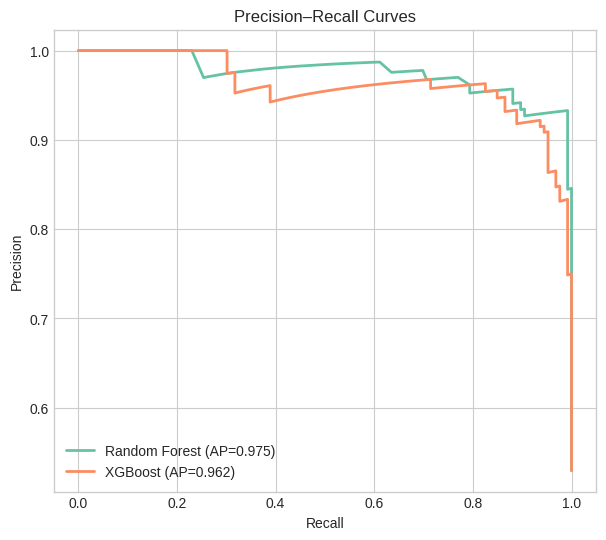


Random Forest with threshold 0.4:
Accuracy:  0.9454
Precision: 0.9313
Recall:    0.9683
F1 Score:  0.9494


In [10]:
# Precision-Recall Curves & Threshold Tuning


from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curve(model, X, y, label_name):
    """
    Fits the model, predicts probabilities,
    plots precision-recall curve, returns PR metrics.
    """
    model.fit(X, y)
    y_scores = model.predict_proba(X_test)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    ap_score = average_precision_score(y_test, y_scores)

    plt.plot(recall, precision, lw=2, label=f"{label_name} (AP={ap_score:.3f})")
    return precision, recall, thresholds

plt.figure(figsize=(7,6))
prec_rf, rec_rf, thr_rf = plot_pr_curve(rf_clf, X_train, y_train, "Random Forest")
prec_xgb, rec_xgb, thr_xgb = plot_pr_curve(xgb_clf, X_train, y_train, "XGBoost")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.grid(True)
plt.show()

# Threshold tuning example (Random Forest)
optimal_threshold = 0.4
y_pred_thresh = (rf_clf.predict_proba(X_test)[:, 1] >= optimal_threshold).astype(int)

print(f"\nRandom Forest with threshold {optimal_threshold}:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_thresh):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_thresh):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_thresh):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_thresh):.4f}")

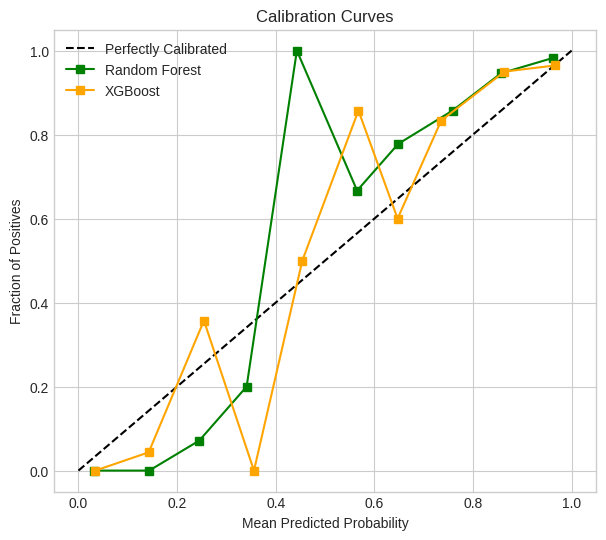

In [11]:
# Probability Calibration Curves


from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

def plot_calibration(model, X_train, y_train, X_test, y_test, name, color):
    """
    Fits model and plots calibration curve.
    """
    model.fit(X_train, y_train)
    prob_pos = model.predict_proba(X_test)[:, 1]

    frac_pos, mean_pred = calibration_curve(y_test, prob_pos, n_bins=10)

    plt.plot(mean_pred, frac_pos, "s-", label=f"{name}", color=color)
    return mean_pred, frac_pos

plt.figure(figsize=(7,6))

# Perfect calibration line
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")

# Plot for Random Forest and XGBoost
plot_calibration(rf_clf, X_train, y_train, X_test, y_test, "Random Forest", "green")
plot_calibration(xgb_clf, X_train, y_train, X_test, y_test, "XGBoost", "orange")

plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves")
plt.legend()
plt.grid(True)
plt.show()